In [1]:
# Male vs Female facial recognition
# Perbandingan dengan 3 algoritma deep learning: VGG, GoogleNet, ResNet
# Hyperparameter Tuning
# Evaluasi, Penarikan kesimpulan
# Github Publication (Individual)


In [2]:
import os
import time
import pandas as pd
import torch
import shutil
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from skimage import io
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
# gpus = gpus = tf.config.list_physical_devices("GPU")

# if gpus:
#     for gpu in gpus:
#         print("Found a GPU with the name: ", gpu)
# else:
#     print ("Failed to detect a GPU.")

In [4]:
data_path='./AIFI/P1'

In [5]:
images_list = os.listdir(data_path + '/Images/')
attributes = data_path + '/list_attribute.txt'
names = data_path + '/class_identity.txt'

In [6]:
try:
    df = pd.read_csv(attributes, on_bad_lines='warn', delim_whitespace=True)
except pd.errors.ParserError as e:
    print(f"Error: {e}")

C:\Users\PC\AppData\Local\Temp\ipykernel_10352\553860008.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(attributes, on_bad_lines='warn', delim_whitespace=True)


In [7]:
df.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
pd.set_option('display.max_columns', None)

df.head()

,202599,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
df.columns

Index(['202599', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [10]:
df.isna().sum()

202599                 0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


In [11]:
clean = data_path + '/clean/'
test_male = data_path + '/test/male'
test_female = data_path + '/test/female'
train_male = data_path + '/train/male'
train_female = data_path + '/train/female'
val_male = data_path + '/val/male'
val_female = data_path + '/val/female'

In [12]:
os.makedirs(clean, exist_ok=True)
os.makedirs(test_male, exist_ok=True)
os.makedirs(test_female, exist_ok=True)
os.makedirs(train_male, exist_ok =True)
os.makedirs(train_female, exist_ok=True)
os.makedirs(val_male, exist_ok =True)
os.makedirs(val_female, exist_ok=True)

In [13]:
for image in images_list:
    try:
        # gender = df.loc[df['202599'] == image, 'Male'].values[0]
        src_path = os.path.join(data_path + '/Images/' + image)
        print(src_path)
        shutil.copy(src_path, clean)
    except IndexError:
        print(f"Image {image} not found in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")

print("Files copied successfully.")

./AIFI/P1/Images/.ipynb_checkpoints
An error occurred: [Errno 13] Permission denied: './AIFI/P1/Images/.ipynb_checkpoints'
./AIFI/P1/Images/000051.jpg
./AIFI/P1/Images/000052.jpg
./AIFI/P1/Images/000065.jpg
./AIFI/P1/Images/000166.jpg
./AIFI/P1/Images/000198.jpg
./AIFI/P1/Images/000201.jpg
./AIFI/P1/Images/000240.jpg
./AIFI/P1/Images/000282.jpg
./AIFI/P1/Images/000352.jpg
./AIFI/P1/Images/000409.jpg
./AIFI/P1/Images/000414.jpg
./AIFI/P1/Images/000439.jpg
./AIFI/P1/Images/000444.jpg
./AIFI/P1/Images/000474.jpg
./AIFI/P1/Images/000525.jpg
./AIFI/P1/Images/000545.jpg
./AIFI/P1/Images/000559.jpg
./AIFI/P1/Images/000572.jpg
./AIFI/P1/Images/000608.jpg
./AIFI/P1/Images/000653.jpg
./AIFI/P1/Images/000716.jpg
./AIFI/P1/Images/000771.jpg
./AIFI/P1/Images/000798.jpg
./AIFI/P1/Images/000810.jpg
./AIFI/P1/Images/000845.jpg
./AIFI/P1/Images/000858.jpg
./AIFI/P1/Images/000873.jpg
./AIFI/P1/Images/000922.jpg
./AIFI/P1/Images/000989.jpg
./AIFI/P1/Images/001140.jpg
./AIFI/P1/Images/001161.jpg
./AIFI/P1

In [14]:
print(clean)

./AIFI/P1/clean/


In [15]:
clean_images = os.listdir(clean)

In [16]:
print(clean_images)

['.ipynb_checkpoints', '000051.jpg', '000052.jpg', '000065.jpg', '000166.jpg', '000198.jpg', '000201.jpg', '000240.jpg', '000282.jpg', '000352.jpg', '000409.jpg', '000414.jpg', '000439.jpg', '000444.jpg', '000474.jpg', '000525.jpg', '000545.jpg', '000559.jpg', '000572.jpg', '000608.jpg', '000653.jpg', '000716.jpg', '000771.jpg', '000798.jpg', '000810.jpg', '000845.jpg', '000858.jpg', '000873.jpg', '000922.jpg', '000989.jpg', '001140.jpg', '001161.jpg', '001218.jpg', '001242.jpg', '001248.jpg', '001256.jpg', '001270.jpg', '001295.jpg', '001401.jpg', '001509.jpg', '001519.jpg', '001613.jpg', '001637.jpg', '001665.jpg', '001708.jpg', '001782.jpg', '001800.jpg', '001894.jpg', '001921.jpg', '001983.jpg', '002085.jpg', '002125.jpg', '002134.jpg', '002150.jpg', '002197.jpg', '002202.jpg', '002223.jpg', '002256.jpg', '002310.jpg', '002362.jpg', '002389.jpg', '002415.jpg', '002427.jpg', '002443.jpg', '002450.jpg', '002456.jpg', '002502.jpg', '002525.jpg', '002527.jpg', '002556.jpg', '002592.jpg

In [17]:
train_images, temp_images = train_test_split(clean_images, test_size=0.4, random_state=42)
test_images, val_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [18]:
print(f'''
Train Image Total :{len(train_images)}
Test Image Total:{len(test_images)}
Validation Image Total: {len(val_images)}
''')


Train Image Total :3010
Test Image Total:1004
Validation Image Total: 1004



In [19]:
def move_images( image_list, target):
    try:
        if target in ['test','train','val']:
            for image in image_list:
                gender = df.loc[df['202599'] == image, 'Male'].values[0]
                src_path = os.path.join(data_path + '/clean/' + image)
                if gender == 1:
                    shutil.copy(src_path, data_path + f'/{target}/' + 'male')
                elif gender == -1:
                    shutil.copy(src_path, data_path + f'/{target}/' + 'female')
    except IndexError:
        print(f"Image {image} not found in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")
print("Files copied successfully.")

Files copied successfully.


In [20]:
move_images(train_images,'train')
move_images(test_images,'test')
move_images(val_images,'val')

Image 182793(1).jpg not found in the DataFrame.
Image 189513(1).jpg not found in the DataFrame.
Image 183050(1).jpg not found in the DataFrame.


In [21]:
epoch = 10
learning_rate = 0.0001
batch_size = 8

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(512),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'val': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path + '/', x),data_transforms[x]) for x in ['train', 'test','val']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train', 'test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
num_classes = len(class_names)

In [23]:
print(num_classes)

2


In [24]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 643
    Root location: ./AIFI/P1/train
    StandardTransform
Transform: Compose(
               Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 1622
    Root location: ./AIFI/P1/test
    StandardTransform
Transform: Compose(
               Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ),

In [25]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000001D51DAFFDD0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x000001D51E0D5AF0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000001D51E487BF0>}


In [26]:
print(dataset_sizes)

{'train': 643, 'test': 1622, 'val': 702}


In [27]:
print(class_names)

['female', 'male']


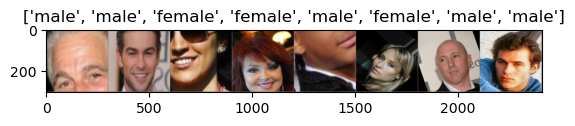

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
!mkdir FaceRecog

A subdirectory or file FaceRecog already exists.


In [30]:
model_ft = models.resnet18() # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

In [32]:
def train_model(model, criterion, optimizer, num_epochs=10,  use_gpu=True):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0

    # Use GPU if available
    device = torch.device("cuda:0" if use_gpu else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []
            phase_start_time = time.time()

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            # Calculate additional metrics
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')
            phase_time = time.time() - phase_start_time

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f} Time: {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, precision, recall, f1, phase_time // 60, phase_time % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                best_epoch = epoch + 1  # Store the epoch number (1-based)
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'./FaceRecog/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f} at epoch {}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def test_model(model,criterion):
    since = time.time()
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []
    phase_start_time = time.time()

    with torch.no_grad():
        for data in dataloaders['test']:
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            else:
                inputs, labels = inputs, labels

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.data
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.float() / dataset_sizes['test']
    
    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    phase_time = time.time() - phase_start_time
    time_elapsed = time.time() - since
    
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(test_loss, test_acc, precision, recall, f1))

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=epoch)

Epoch 1/10
----------


D:\Anaconda\envs\facerecog_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train Loss: 0.2706 Acc: 0.4930 Precision: 0.5303 Recall: 0.4930 F1: 0.4812 Time: 0m 6s
val Loss: 0.0965 Acc: 0.6125 Precision: 0.6626 Recall: 0.6125 F1: 0.5173 Time: 0m 4s

Epoch 2/10
----------
train Loss: 0.0905 Acc: 0.6236 Precision: 0.6074 Recall: 0.6236 F1: 0.5934 Time: 0m 5s
val Loss: 0.0912 Acc: 0.6068 Precision: 0.6104 Recall: 0.6068 F1: 0.5359 Time: 0m 4s

Epoch 3/10
----------
train Loss: 0.0864 Acc: 0.6081 Precision: 0.5899 Recall: 0.6081 F1: 0.5855 Time: 0m 4s
val Loss: 0.0882 Acc: 0.5869 Precision: 0.5670 Recall: 0.5869 F1: 0.5347 Time: 0m 4s

Epoch 4/10
----------
train Loss: 0.0839 Acc: 0.6205 Precision: 0.6044 Recall: 0.6205 F1: 0.5972 Time: 0m 4s
val Loss: 0.0825 Acc: 0.6125 Precision: 0.6288 Recall: 0.6125 F1: 0.6149 Time: 0m 4s

Epoch 5/10
----------
train Loss: 0.0820 Acc: 0.6423 Precision: 0.6308 Recall: 0.6423 F1: 0.6249 Time: 0m 4s
val Loss: 0.0973 Acc: 0.5997 Precision: 0.6171 Recall: 0.5997 F1: 0.5022 Time: 0m 4s

Epoch 6/10
----------
train Loss: 0.0799 Acc: 0

In [35]:
model_ft = test_model(model_ft, criterion)

Test complete in 0m 4s
Test Loss: 0.0786 Acc: 0.6393 Precision: 0.6383 Recall: 0.6393 F1: 0.6388


In [36]:
print(use_gpu)

True
